## 1. Постановка задачи


Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных




[Данные](https://drive.google.com/file/d/1qCepmC3BPtRn85v8c91aZjaKy9Jyq23b/view?usp=sharing)

## План работы


**1. Первичная обработка данных**

В рамках этой части вам предстоит сформировать набор данных на основе предложенных нами источников информации, а также обработать пропуски и выбросы в данных.

**2. Разведывательный анализ данных (EDA)**

Вам необходимо будет исследовать данные, нащупать первые закономерности и выдвинуть гипотезы.

**3. Отбор и преобразование признаков**

На этом этапе вы перекодируете и преобразуете данные таким образом, чтобы их можно было использовать при решении задачи регрессии — для построения модели.

**4. Решение задачи регрессии: линейная регрессия и деревья решений**

На данном этапе вы построите свои первые прогностические модели и оцените их качество. Тем самым вы создадите так называемый baseline, который поможет вам ответить на вопрос: «Решаема ли вообще представленная задача?»

**5. Решение задачи регрессии: ансамбли моделей и построение прогноза**

На заключительном этапе вы сможете доработать своё предсказание с использованием более сложных алгоритмов и оценить, с помощью какой модели возможно сделать более качественные прогнозы.

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

sns.set(style='darkgrid')

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Собственные функции

In [62]:
def get_RMSLE(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

Прочитаем наш файл с исходными данными:

In [63]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S'). 

Определите временные рамки (без учета времени), за которые представлены данные.

In [64]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['pickup_datetime'].describe()

count                          1458644
mean     2016-04-01 10:10:24.940037120
min                2016-01-01 00:00:17
25%      2016-02-17 16:46:04.249999872
50%                2016-04-01 17:19:40
75%      2016-05-15 03:56:08.750000128
max                2016-06-30 23:59:39
Name: pickup_datetime, dtype: object

Данные представлены с 1 января по 30 июня 2016 года

### Задание 2.2
Посмотрим на пропуски. 
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [65]:
taxi_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Пропуски отсутствуют

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков. 

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [66]:
# Сколько уникальных таксопарков
print(f"Количество уникальных таксопаркоа: {taxi_data['vendor_id'].nunique()}")
display(taxi_data['vendor_id'].value_counts())
print(f"Максимальное количество пассажиров: {taxi_data['passenger_count'].max()}")
print('Время поездки, с:')
print(f"\tМинимальное: {taxi_data['trip_duration'].min()}")
print(f"\tМедианное: {taxi_data['trip_duration'].median()}")
print(f"\tСреднее: {taxi_data['trip_duration']. mean():.0f}")
print(f"\tМаксимальное: {taxi_data['trip_duration']. max()}")

Количество уникальных таксопаркоа: 2


vendor_id
2    780302
1    678342
Name: count, dtype: int64

Максимальное количество пассажиров: 9
Время поездки, с:
	Минимальное: 1
	Медианное: 662.0
	Среднее: 959
	Максимальное: 3526282


Что интересного мы увидели? В данных присутствуют поездки, продолжительность которых составляет одну секунду, а также поездки, продолжительность которых больше 40 дней. Сразу приходит мысль, что это выбросы.

Чтобы однозначно обозначить такие записи в таблице как выбросы, нам необходимо произвести более глубокий анализ данных с подключением дополнительной информации.

Примечание. На основе полученной статистической информации о целевом признаке trip_duration мы также делаем важный вывод, что использование среднего в качестве центральной меры распределения длительности поездок будет грубой ошибкой. Лучше всего подойдут меры, не зависящие от выбросов, такие как усечённое среднее, логарифмическое среднее или медиана. При проведении исследований мы будем использовать медиану, а наша метрика качества моделей будет завязана на логарифмическом среднем.

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Начнём с временных характеристик. Как нам уже известно, хранить дату и время в формате datetime как категориальный признак редко имеет смысл, поэтому их разбивают на отдельные признаки. Эти признаки могут как стать основными факторами при построении модели, так и быть вспомогательными для извлечения информации из других таблиц.

### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [67]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.weekday
    return df

taxi_data = add_datetime_features(taxi_data)

# Saturday trip count
print(f"Число поездок в субботу: {taxi_data[taxi_data['pickup_day_of_week'] == 5].shape[0]}")
# Daily trip count
print(f"Количество поездок ежедневно: {taxi_data['pickup_date'].value_counts().mean():.0f}")

Число поездок в субботу: 220868
Количество поездок ежедневно: 8015


От того, является ли день праздничным, часто зависит ситуация на дорогах. Большое количество автомобилей создаёт пробки и потенциально увеличивает длительность совершаемой на такси поездки.

Давайте добавим в наш датасет информацию о том, является ли день праздничным. Для этого мы собрали даты всех праздничных дней в Америке за 2016 год. Данные представлены в табличном формате CSV и содержат три столбца:

day — день недели;
date — дата;
holiday — наименование праздника.

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [68]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

def add_holiday_features(taxi_data, holiday_data):
    holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date
    taxi_data['pickup_holiday'] = 0 # No holiday by default
    # For all holiday dates save holiday status
    for date in holiday_data['date']:
        taxi_data.loc[taxi_data['pickup_date'] == date, 'pickup_holiday'] = 1
    # taxi_data['pickup_holiday'] = taxi_data['pickup_date'].apply(lambda x: 1 if x in holiday_data['date'] else 0 )
    
    return taxi_data

taxi_data = add_holiday_features(taxi_data, holiday_data)

# Median trip duration on holidays
print(f"Длительность поездки в выходные, с: {taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median()}")

Длительность поездки в выходные, с: 585.0


Теперь, когда мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации.

Например, зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться OSRM API.

OSRM (Open Source Routing Machine) — это открытый бесплатный ресурс, который активно используется во многих сервисах, предполагающих построение кратчайшего маршрута. Он позволяет построить оптимальный кусочно-линейный путь из точки А в точку B, а также узнать его примерную длительность и длину. У данного сервиса есть API, с которым вы можете познакомиться в документации.

Проблема заключается в том, что, так как в наших данных содержится информация о более чем одном миллионе поездок, подгрузка данных с помощью API и их предобработка может занять несколько часов, а при слабом интернет-соединении — и дней. Поэтому мы заранее подготовили выгрузку данных из OSRM API для каждой поездки из тренировочной и тестовой выборок нашего набора данных.

Файлы с данными из OSRM для поездок из тренировочной таблицы вы можете найти здесь. Наборы данных представлены в табличном формате CSV. Нас будут интересовать только следующие столбцы:

- id — идентификатор поездки;
- total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
- total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
- number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

[Данные](https://drive.google.com/file/d/1ecWjor7Tn3HP7LEAm5a0B_wrIfdcVGwR/view?usp=sharing)

In [69]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')

def add_osrm_features(taxi_data, osrm_data):
    osrm_data = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    taxi_data = taxi_data.merge(osrm_data, on='id', how='left')
    
    return taxi_data

taxi_data = add_osrm_features(taxi_data, osrm_data)

# 1. Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM? 
print(f"Разница между медианной длительностью поездки из данных и из OSRM: {taxi_data['trip_duration'].median() - taxi_data['total_travel_time'].median():.0f}")
# 2. Сколько строк содержат пропуски?
print('Пропуски в данных:')
display(taxi_data.isna().sum())

Разница между медианной длительностью поездки из данных и из OSRM: 372
Пропуски в данных:


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

С помощью географических характеристик можно извлечь ещё немного информации. Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере, а также узнать направление движения автомобиля.

In [70]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [71]:
def add_geographical_features(taxi_data):
    taxi_data['haversine_distance'] = taxi_data.apply(lambda x: get_haversine_distance(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

    taxi_data['direction'] = taxi_data.apply(lambda x: get_angle_direction(x['pickup_latitude'], x['pickup_longitude'], x['dropoff_latitude'], x['dropoff_longitude']), axis=1)
    
    return taxi_data

taxi_data = add_geographical_features(taxi_data)

print(f"Медианное расстояние по формуле гаверсинуса для поездок (км): {taxi_data['haversine_distance'].median():.2f}")

Медианное расстояние по формуле гаверсинуса для поездок (км): 2.09


Следующая методика манипуляций с географическими данными — это применение кластеризации по географическим координатам. Идея заключается в том, чтобы сгруппировать все поездки в зависимости от координат начала и конца поездки с помощью методов кластеризации, тем самым добавив информацию о районах, в которых находятся точки старта и конца поездки.

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


В качестве метода кластеризации воспользуемся алгоритмом K-Means. Возьмём десять кластеров и обучим его на данных, сформированных из широты и долготы всех точек начала и конца поездок.

In [72]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42, n_init=10)
kmeans.fit(coords)

def add_cluster_features(taxi_data, kmeans):
    coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
    taxi_data['geo_cluster'] = kmeans.predict(coords)
    
    return taxi_data

taxi_data = add_cluster_features(taxi_data, kmeans)
taxi_data['geo_cluster'].value_counts()

geo_cluster
1    592117
0    392108
6    340489
8     45518
4     40234
5     32799
7     15355
9        18
3         4
2         2
Name: count, dtype: int64

Другим важным фактором, потенциально влияющим на дорожное движение, является погода. Так, например, логично предположить, что снег и дождь могут затруднять движение и увеличивать время поездки.

[Здесь](https://lms-cdn.skillfactory.ru/assets/courseware/v1/0f6abf84673975634c33b0689851e8cc/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block/weather_data.zip) вы можете найти набор данных, содержащий информацию о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:

- time — дата измерения (с интервалом в час);
- temperature — температура;
- visibility — видимость;
- wind speed — средняя скорость ветра;
- precip — количество осадков;
- events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [73]:
weather_data = pd.read_csv('data/weather_data.csv')

def add_weather_features(taxi_data:pd.DataFrame, weather_data:pd.DataFrame):
    weather_data['date'] = pd.to_datetime(weather_data['date'])
    weather_data['date'] = weather_data['date'].dt.date
    weather_data_trim = weather_data[['date', 'hour', 'temperature', 'visibility', 'wind speed', 'precip', 'events']]
    
    taxi_data = taxi_data.merge(
        weather_data_trim, 
        how='left', 
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour']
    )
    # taxi_data = taxi_data.drop(['date', 'hour'])
    
    return taxi_data

taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data = taxi_data.drop(['date', 'hour'], axis=1)

print(f"Количество поездок в снежную погоду: {taxi_data['events'].value_counts()['Snow']}")

print(f"Процент пропуска погодных условий: {taxi_data['temperature'].isna().sum()/taxi_data.shape[0]*100:.2f}%")


Количество поездок в снежную погоду: 13126
Процент пропуска погодных условий: 0.82%


Теперь, когда мы расширили датасет новыми признаками, нам необходимо немного его подчистить. О чём речь?

- В результате добавления новой информации у нас появились пропущенные значения в данных.
- Благодаря новым добавленным признакам мы сможем более детально изучить поездки с аномальной длительностью.

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски. 
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам. 

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [74]:
def fill_null_data(taxi_data):
    for col in ['temperature', 'visibility', 'wind speed', 'precip']:
        taxi_data[col] = taxi_data[col].fillna(
            taxi_data.groupby('pickup_date')[col].transform('median')
        )
        
        taxi_data['events'] = taxi_data['events'].fillna('None')
        
    for col in ['total_distance', 'total_travel_time', 'number_of_steps']:
        taxi_data[col] = taxi_data[col].fillna(taxi_data[col].median())
        
    return taxi_data

taxi_data = fill_null_data(taxi_data)

print(f"Медианная температруа после заполнения пропусков: {taxi_data['temperature'].median():.1f} ºC")

Медианная температруа после заполнения пропусков: 11.1 ºC


В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


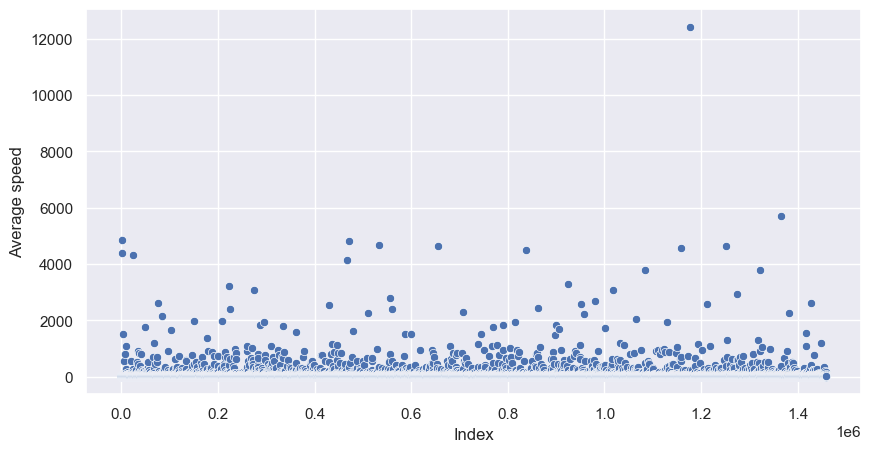

In [75]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 

б) Сколько выбросов по признаку скорости вам удалось найти?

In [76]:
print(f"Количество выбросов по длительности поездки (больше суток): {(taxi_data['trip_duration'] > 24*3600).sum()}")
taxi_data = taxi_data[taxi_data['trip_duration'] <= 24*3600]
print(f"Количество выбросов по скорости (больше 300 км/ч): {(avg_speed > 300).sum()}")
taxi_data = taxi_data.drop(index=avg_speed[avg_speed > 300].index)

Количество выбросов по длительности поездки (больше суток): 4
Количество выбросов по скорости (больше 300 км/ч): 407


## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [77]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным? 
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

p_value = 0.000e+00
Распределение отлично от нормального


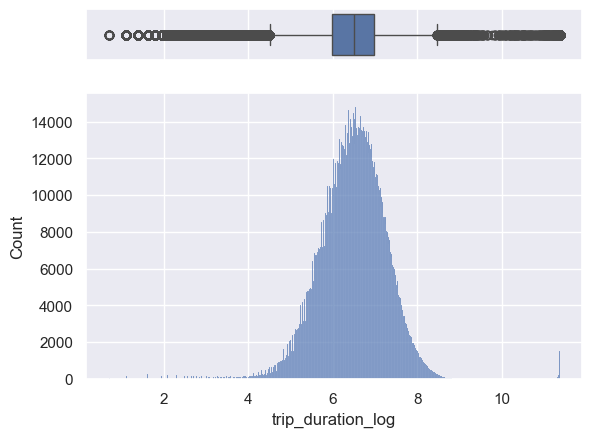

In [78]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(taxi_data['trip_duration_log'], orient='h', ax=ax_box)
sns.histplot(data=taxi_data, x='trip_duration_log', ax=ax_hist)
ax_box.set_xlabel('');

# Normal test
alpha = 0.05
_, p_value = stats.normaltest(taxi_data['trip_duration_log'])
print(f'p_value = {p_value:.3e}')
if p_value < alpha:
    print(f'Распределение отлично от нормального')
else:
    print('Нормальное распределение')

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

Сравните два распределения между собой.

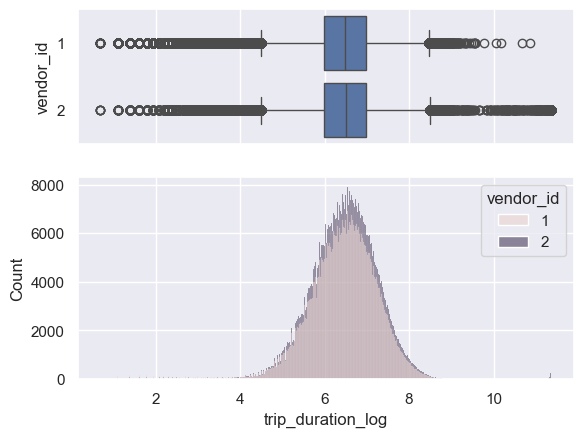

In [79]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.40, .60)})
sns.boxplot(data = taxi_data, orient='h', ax=ax_box, x='trip_duration_log', y='vendor_id')
sns.histplot(data=taxi_data, x='trip_duration_log', ax=ax_hist, hue='vendor_id')
ax_box.set_xlabel('');

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

Сравните два распределения между собой.

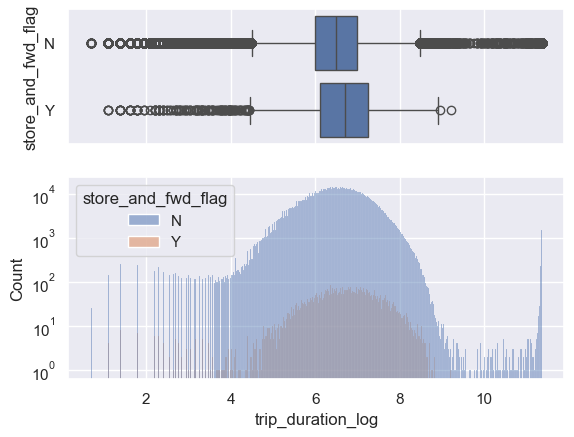

In [80]:
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.40, .60)})
sns.boxplot(data = taxi_data, orient='h', ax=ax_box, x='trip_duration_log', y='store_and_fwd_flag')
sns.histplot(data=taxi_data, x='trip_duration_log', ax=ax_hist, hue='store_and_fwd_flag')
ax_hist.set_yscale('log')
ax_box.set_xlabel('');

Распределения в группах практически не отличаются, признак store_and_fwd_flag не имеет значения при определении длительности поездки.

Примечание. Если внимательно присмотреться к распределению длительности поездок в зависимости от признака store_and_fwd_flag, становится ясно, что наиболее длительные поездки принадлежат к группе N (не хранить и не пересылать поездку). Таким образом, флаг сохраняется только для кратковременных поездок, а для аномальных многочасовых — не сохраняется.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

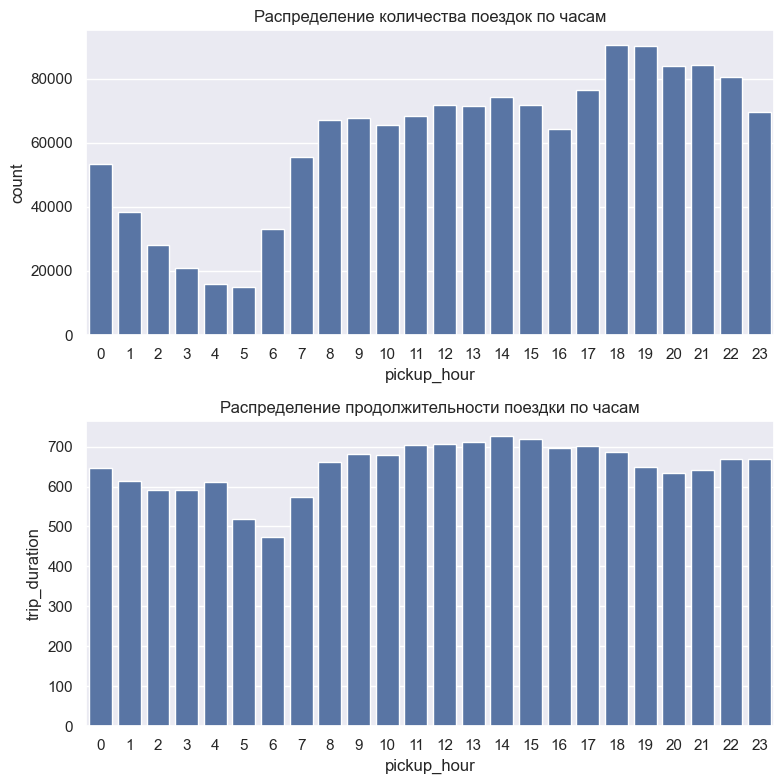

In [81]:
fig, axes = plt.subplots(2,1, figsize=(8,8))

sns.countplot(data=taxi_data, x='pickup_hour', ax=axes[0])
axes[0].set_title('Распределение количества поездок по часам')

duration_by_hour = taxi_data.groupby('pickup_hour')['trip_duration'].median()
sns.barplot(data=duration_by_hour, ax=axes[1])
axes[1].set_title('Распределение продолжительности поездки по часам');
fig.tight_layout()

- Реже всего такси заказывают поздно ночью: 00:00-05:00
- Дольше всего поездки после обеда: с 13:00 по 18:00

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


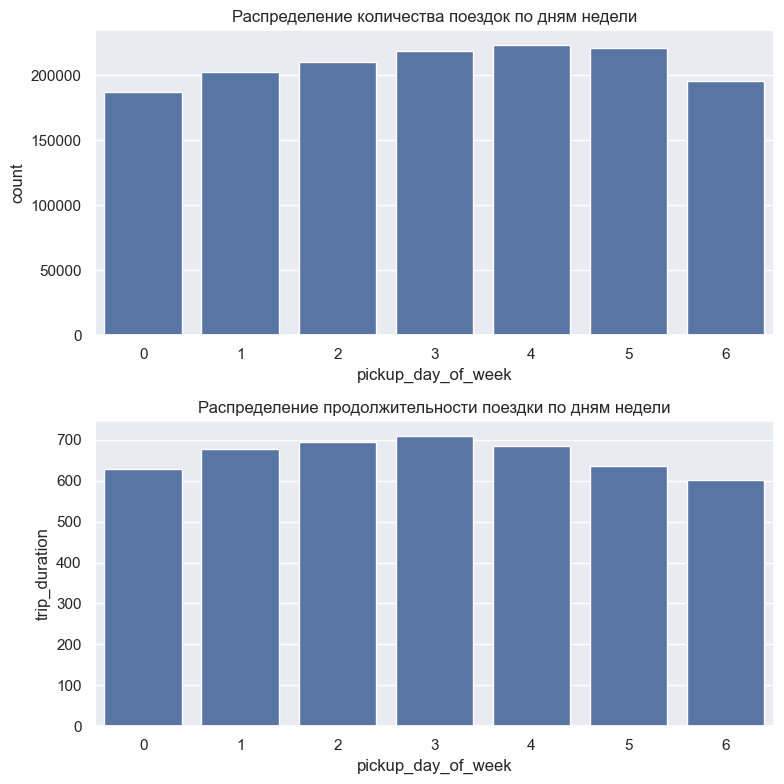

In [82]:
fig, axes = plt.subplots(2,1, figsize=(8,8))

sns.countplot(data=taxi_data, x='pickup_day_of_week', ax=axes[0])
axes[0].set_title('Распределение количества поездок по дням недели')

duration_by_week = taxi_data.groupby('pickup_day_of_week')['trip_duration'].median()
sns.barplot(data=duration_by_week, ax=axes[1])
axes[1].set_title('Распределение продолжительности поездки по дням недели');
fig.tight_layout()

- Наибольшее количество поездок совершается в Пятницу;
- Медианная длительность поездок наименьшая в Воскресенье

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно. 

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

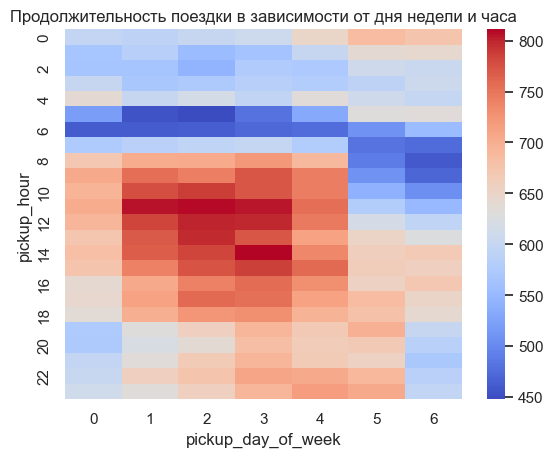

In [83]:
duration_pivot = taxi_data.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

sns.heatmap(duration_pivot, cmap='coolwarm')
plt.title('Продолжительность поездки в зависимости от дня недели и часа');

- Самые продолжительные поездки (в медианном смысле) наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов.
- Наибольшая медианная длительность поездки наблюдалась в четверг в 14 часов дня.

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude). 
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


/Users/tochka/APP_Final_Project/learning_task/.venv/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/tochka/APP_Final_Project/learning_task/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


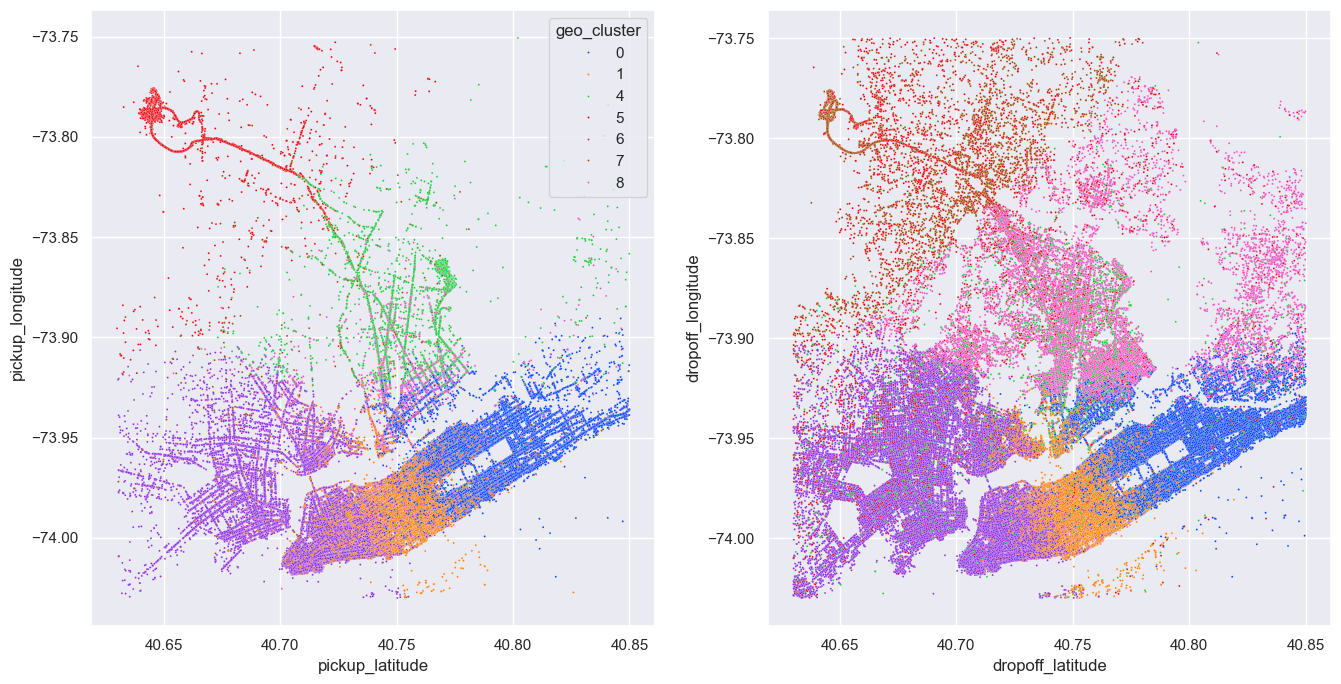

In [84]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

# Let us keep only New-York districts
new_york_taxi_data = taxi_data[(taxi_data['pickup_longitude'].between(*city_long_border))
                               & (taxi_data['pickup_latitude'].between(*city_lat_border))
                               & (taxi_data['dropoff_longitude'].between(*city_long_border))
                               & (taxi_data['dropoff_latitude'].between(*city_lat_border))
                               ]

fig, (pickup_ax, dropoff_ax) = plt.subplots(
    ncols=2,
    figsize=(16,8)
)

sns.scatterplot(data=new_york_taxi_data, x='pickup_latitude', y='pickup_longitude', legend='brief', ax=pickup_ax, hue='geo_cluster', palette='bright', s=2)
sns.scatterplot(data=new_york_taxi_data, x='dropoff_latitude', y='dropoff_longitude', legend=False, ax=dropoff_ax, hue='geo_cluster', palette='bright', s=2);


- Два кластера находятся за пределами Нью-Йорка
- Высадка пассажиров имеет бОльший разброс, чем посадка

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [85]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [86]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках. 

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности? - **id**

б) Утечка данных (data leak) - это ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных? - dropoff_datetime

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [87]:
train_data = train_data.drop(['id', 'dropoff_datetime'], axis=1)
print(f'Осталось столбцов: {len(train_data.columns)}')

Осталось столбцов: 25


Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [88]:
drop_columns = ['pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


Теперь займёмся кодированием категориальных признаков. В наших данных к категориальным можно отнести следующие признаки:

- vendor_id;
- store_and_fwd_flag;
- pickup_day_of_week;
- geo_cluster;
- events.

Первые два (vendor_id и store_and_fwd_flag) из них являются бинарными (имеют два уникальных значения). Давайте их закодируем

### Задание 4.2.

Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [89]:
vendor_store_enc = preprocessing.OrdinalEncoder(categories=[(1, 2), ('N', 'Y')])
train_data[['vendor_id','store_and_fwd_flag']] = vendor_store_enc.fit_transform(train_data[['vendor_id','store_and_fwd_flag']])

print(f"Среднее по vendor_id: {train_data['vendor_id'].mean():.2f}")
print(f"Среднее по store_and_fwd_flag: {train_data['store_and_fwd_flag'].mean():.3f}")

Среднее по vendor_id: 0.53
Среднее по store_and_fwd_flag: 0.006


Следующие три признака (pickup_day_of_week, geo_cluster, events) являются номинальными.  Для них отлично подойдёт однократное кодирование.

### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEncoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.

Пример использования:

``` python
# Получаем закодированные имена столбцов
column_names = one_hot_encoder.get_feature_names_out()
# Составляем DataFrame из закодированных признаков
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
```

В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events. 


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [90]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']

onehot_enc = preprocessing.OneHotEncoder(drop='first', sparse_output=False)
data_onehot = onehot_enc.fit_transform(train_data[columns_to_change])
column_names = onehot_enc.get_feature_names_out()
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(f"Количество сгенерированных бинарных столбцов: {data_onehot.shape[1]}")

Количество сгенерированных бинарных столбцов: 18


Добавим полученную таблицу с закодированными признаками:

In [91]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [92]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Далее нам необходимо определить тип валидации — схему, по которой мы будем оценивать качество построенных моделей. Так как наш набор данных довольно большой (почти 1.5 миллиона наблюдений), то мы свободно можем использовать hold-out-валидацию. Использование k-fold-валидации и тем более leave-one-out-валидации при таком объёме данных будет избыточным и времязатратным.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [93]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [94]:
select_best = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=25)

select_best.fit(X_train, y_train_log)
best_columns = select_best.get_feature_names_out()

X_train = X_train[best_columns]
X_valid = X_valid[best_columns]

print(f'Best columns: {best_columns}')

Best columns: ['vendor_id' 'passenger_count' 'pickup_longitude' 'pickup_latitude'
 'dropoff_longitude' 'dropoff_latitude' 'store_and_fwd_flag' 'pickup_hour'
 'pickup_holiday' 'total_distance' 'total_travel_time' 'number_of_steps'
 'haversine_distance' 'temperature' 'pickup_day_of_week_1'
 'pickup_day_of_week_2' 'pickup_day_of_week_3' 'pickup_day_of_week_4'
 'pickup_day_of_week_5' 'pickup_day_of_week_6' 'geo_cluster_1'
 'geo_cluster_4' 'geo_cluster_5' 'geo_cluster_7' 'geo_cluster_8']


Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов. 


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [95]:
scaler = preprocessing.MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=best_columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=best_columns)

print(f"Среднее арифм. первого предиктора: {X_valid.iloc[:,0].mean():.2f}")

Среднее арифм. первого предиктора: 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [96]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train_log)
y_train_log_predict = lin_reg.predict(X_train)
y_valid_log_predict = lin_reg.predict(X_valid)

linreg_rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_predict))
linreg_rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_predict))

print(f"RMSLE на тренировочной выборке: {linreg_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {linreg_rmsle_valid:.2f}")

RMSLE на тренировочной выборке: 0.53
RMSLE на валидационной выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [97]:
# Get polynomial features
pf = preprocessing.PolynomialFeatures(include_bias=False)
pf.fit(X_train)
X_train_pf = pf.transform(X_train)
X_valid_pf = pf.transform(X_valid)

# Fit polynomial regression
lin_reg_poly = linear_model.LinearRegression()
lin_reg_poly.fit(X_train_pf, y_train_log)
y_train_log_predict = lin_reg_poly.predict(X_train_pf)
y_valid_log_predict = lin_reg_poly.predict(X_valid_pf)

linreg_poly_rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_predict))
linreg_poly_rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_predict))

print(f"RMSLE на тренировочной выборке: {linreg_poly_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {linreg_poly_rmsle_valid:.2f}")

RMSLE на тренировочной выборке: 0.47
RMSLE на валидационной выборке: 0.61


Наблюдается переобучение!

### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha$ установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [98]:
ridge_poly = linear_model.Ridge(alpha=1)

# Fit polynomial regression
ridge_poly.fit(X_train_pf, y_train_log)
y_train_log_predict = ridge_poly.predict(X_train_pf)
y_valid_log_predict = ridge_poly.predict(X_valid_pf)

ridge_poly_rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_predict))
ridge_poly_rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_predict))

print(f"RMSLE на тренировочной выборке: {ridge_poly_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {ridge_poly_rmsle_valid:.2f}")

RMSLE на тренировочной выборке: 0.48
RMSLE на валидационной выборке: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию. 

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [99]:
dtree = tree.DecisionTreeRegressor(random_state=42)

# Fit polynomial regression
dtree.fit(X_train, y_train_log)
y_train_log_predict = dtree.predict(X_train)
y_valid_log_predict = dtree.predict(X_valid)

dtree_rmsle_train = np.sqrt(metrics.mean_squared_error(y_train_log, y_train_log_predict))
dtree_rmsle_valid = np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_log_predict))

print(f"RMSLE на тренировочной выборке: {dtree_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {dtree_rmsle_valid:.2f}")

RMSLE на тренировочной выборке: 0.00
RMSLE на валидационной выборке: 0.57


Наблюдается переобучение

### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Параметр random_state задайте равным 42.

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


RMSLE на тренировочной выборке: 0.41
RMSLE на валидационной выборке: 0.43


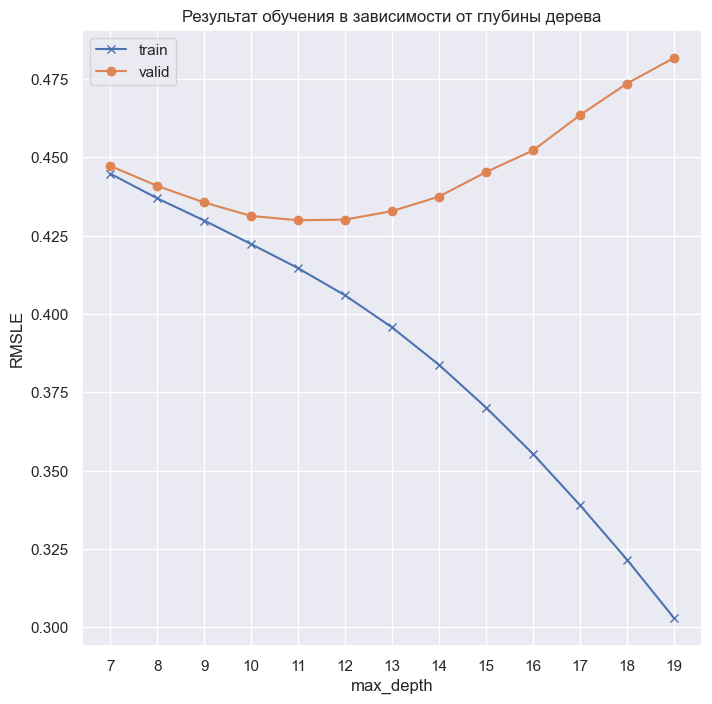

In [100]:
max_depths = range(7, 20)

estimator = lambda max_depth: tree.DecisionTreeRegressor(
    max_depth=max_depth, 
    random_state=42
)

train_rmsle = []
valid_rmsle = []

# Since task is specific, let us create own grid search
for max_depth in max_depths:
    dtree = estimator(max_depth)
    dtree.fit(X_train, y_train_log)
    
    train_rmsle.append(get_RMSLE(dtree, X_train, y_train_log))
    valid_rmsle.append(get_RMSLE(dtree, X_valid, y_valid_log))

# Plot train and test plots
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(max_depths, train_rmsle, marker='x', label='train')
ax.plot(max_depths, valid_rmsle, marker='o', label='valid')
ax.set_xticks(max_depths)
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSLE')
ax.set_title('Результат обучения в зависимости от глубины дерева')
ax.legend();

# Define metric for the best max depth
opt_max_depth = 12
dtree = estimator(opt_max_depth)
dtree.fit(X_train, y_train_log)
dtree_opt_rmsle_train = get_RMSLE(dtree, X_train, y_train_log)
dtree_opt_rmsle_valid = get_RMSLE(dtree, X_valid, y_valid_log)

print(f"RMSLE на тренировочной выборке: {dtree_opt_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {dtree_opt_rmsle_valid:.2f}")


# EXAMPLE OF GRIDSEARCH USAGE
# # Let us keep data together to conduct GridSearch with predefined validation set
# X_search = pd.concat((X_train, X_valid)).reset_index(drop=True)
# y_log_search = pd.concat((y_train_log, y_valid_log)).reset_index(drop=True)
# # Validation data is the last one, let us keep zeros for the validation
# valid_index = np.hstack((
#     -1*np.ones(len(y_train_log)),
#     np.zeros(len(y_valid_log))
# )).astype('int64')

# # Let us create own metric for scoring
# def neg_RMSLE_scorer(estimator, X, y_true):
#     y_pred = estimator.predict(X)
#     return -np.sqrt(metrics.mean_squared_error(y_true, y_pred))

# # Let us keep our own validation set
# ps = model_selection.PredefinedSplit(valid_index)

# estimator = lambda: tree.DecisionTreeRegressor(random_state=42)

# gsearch = model_selection.GridSearchCV(
#     estimator=estimator(),
#     param_grid={'max_depth': max_depths},
#     cv=ps,
#     scoring=neg_RMSLE_scorer,
# )
# gsearch.fit(X_search, y_log_search)

По графику определяем, что оптимальная глубина дерева = 12

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### Задание 6.1.

Постройте модель случайного леса на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* n_estimators=200,
* max_depth=12,
* criterion='squared_error',
* min_samples_split=20,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [101]:
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_split=20,
    random_state=42,
    verbose=True,
    n_jobs=-1,
)
rf.fit(X_train, y_train_log)

rf_rmsle_train = get_RMSLE(rf, X_train, y_train_log)
rf_rmsle_valid = get_RMSLE(rf, X_valid, y_valid_log)

print(f"RMSLE на тренировочной выборке: {rf_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {rf_rmsle_valid:.2f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    2.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s


RMSLE на тренировочной выборке: 0.40
RMSLE на валидационной выборке: 0.41


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    1.2s finished


Благодаря параллельному обучению нескольких деревьев модель случайного леса дала нам небольшой прирост качества по сравнению с обычным деревом решений.

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6, 
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [106]:
gb = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True,
)
gb.fit(X_train, y_train_log)

gb_rmsle_train = get_RMSLE(gb, X_train, y_train_log)
gb_rmsle_valid = get_RMSLE(gb, X_valid, y_valid_log)

print(f"RMSLE на тренировочной выборке: {gb_rmsle_train:.2f}")
print(f"RMSLE на валидационной выборке: {gb_rmsle_valid:.2f}")

      Iter       Train Loss   Remaining Time 
         1           0.3110            7.65m
         2           0.2247            7.55m
         3           0.1985            7.47m
         4           0.1873            7.34m
         5           0.1818            7.23m
         6           0.1783            7.13m
         7           0.1749            7.10m
         8           0.1718            7.03m
         9           0.1705            6.98m
        10           0.1693            6.87m
        20           0.1595            6.02m
        30           0.1540            5.26m
        40           0.1505            4.49m
        50           0.1475            3.74m
        60           0.1457            2.99m
        70           0.1433            2.26m
        80           0.1409            1.50m
        90           0.1393           44.89s
       100           0.1380            0.00s
RMSLE на тренировочной выборке: 0.37
RMSLE на валидационной выборке: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Наилучший результат показал градиентный бустинг над деревьями решений

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


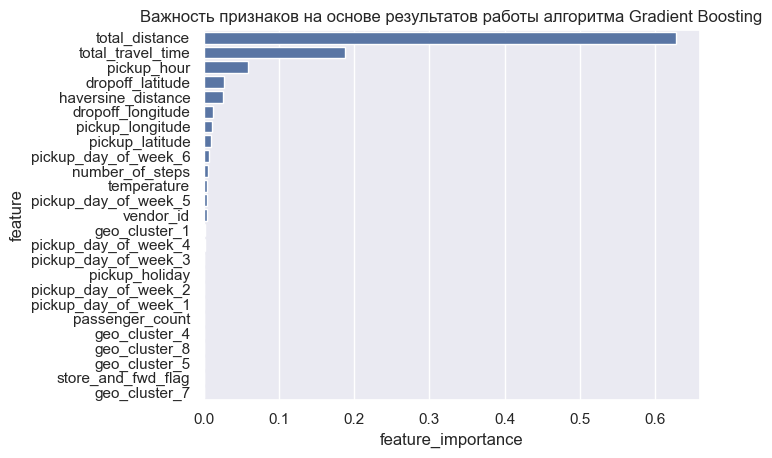

In [107]:
importance_df = pd.DataFrame(
    {
        'feature': best_columns,
        'feature_importance': gb.feature_importances_
    }
)
importance_df = importance_df.sort_values(by='feature_importance', ascending=False)

sns.barplot(data=importance_df, y='feature', x='feature_importance', orient='h');
plt.title('Важность признаков на основе результатов работы алгоритма Gradient Boosting');

Наиболее значимыми признаками оказались: 'total_distance', 'total_travel_time', 'pickup_hour'

Несмотря на все преимущества, у метрики RMSLE есть один недостаток — она не является интерпретируемой. Нам хотелось бы понять, насколько наша итоговая модель хорошо предсказывает целевой признак с точки зрения бизнес-процесса. Точнее, мы бы хотели получить более понятное представление об ошибке прогноза длительности поездки.

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


Не забываем переводить из логарифмического масштаба в изначальный:
$$
    y_i = exp(z_i) - 1
$$

In [108]:
y_valid_log_predict = gb.predict(X_valid)

# Transfer log-scale to linear
y_valid_predict = np.exp(y_valid_log_predict) - 1
y_valid = np.exp(y_valid_log) - 1

gb_MeAE = metrics.median_absolute_error(y_valid, y_valid_predict)
print(f"MeAE на валидационной выборке, мин: {gb_MeAE/60:.1f}")

MeAE на валидационной выборке, мин: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [109]:
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [110]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_data(test_data)

# test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
# test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data[['vendor_id','store_and_fwd_flag']] = vendor_store_enc.transform(test_data[['vendor_id','store_and_fwd_flag']])
test_data_onehot = onehot_enc.transform(test_data[columns_to_change])
# column_names = onehot_enc.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_columns]
X_test = pd.DataFrame(scaler.transform(X_test), columns=best_columns)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [111]:
y_test_predict = gb.predict(X_test)
y_test_predict = np.exp(y_test_predict) - 1
submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)

### **В качестве бонуса**

В завершение по ансамблевым мы предлагаем вам попробовать улучшить свое предсказание, воспользовавшись моделью экстремального градиентного бустинга (XGBoost) из библиотеки xgboost.

**XGBoost** - современная модель машинного обучения, которая является продолжением идеи градиентного бустинга Фридмана. У нее есть несколько преимуществ по сравнению с классической моделью градиентного бустинга из библиотеки sklearn: 
- повышенная производительность путем параллелизации процесса обучения, 
- повышенное качество решения за счет усовершенствования алгоритма бустинга, 
- меньшая склонность к переобучению и широкий функционал возможности управления параметрами модели.


Для ее использования необходимо для начала установить пакет xgboost:

In [118]:
#!pip install xgboost

После чего модуль можно импортировать:

In [120]:
import xgboost as xgb

Перед обучением модели необходимо перевести наборы данных в тип данных xgboost.DMatrix:

In [121]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log, feature_names=list(best_columns))
dvalid = xgb.DMatrix(X_valid, label=y_valid_log, feature_names=list(best_columns))
dtest = xgb.DMatrix(X_test, feature_names=list(best_columns))

Обучение модели XGBoost происходит с помощью метода train, в который необходимо передать параметры модели, набор данных, количество базовых моделей в ансамбле, а также дополнительные параметры:


In [122]:
# Гиперпараметры модели
xgb_pars = {'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.9, 
            'max_depth': 6, 'subsample': 0.9, 'lambda': 1, 'nthread': -1, 
            'booster' : 'gbtree', 'eval_metric': 'rmse', 'objective': 'reg:squarederror'
           }
# Тренировочная и валидационная выборка
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
# Обучаем модель XGBoost
model = xgb.train(
    params=xgb_pars, #гиперпараметры модели
    dtrain=dtrain, #обучающая выборка
    num_boost_round=300, #количество моделей в ансамбле
    evals=watchlist, #выборки, на которых считается матрица
    early_stopping_rounds=20, #раняя остановка
    maximize=False, #смена поиска максимума на минимум
    verbose_eval=10 #шаг, через который происходит отображение метрик
)

[0]	train-rmse:0.74025	valid-rmse:0.74223
[10]	train-rmse:0.49112	valid-rmse:0.49370
[20]	train-rmse:0.44032	valid-rmse:0.44316
[30]	train-rmse:0.42598	valid-rmse:0.42904
[40]	train-rmse:0.41908	valid-rmse:0.42234
[50]	train-rmse:0.41376	valid-rmse:0.41730
[60]	train-rmse:0.41019	valid-rmse:0.41413
[70]	train-rmse:0.40694	valid-rmse:0.41111
[80]	train-rmse:0.40418	valid-rmse:0.40867
[90]	train-rmse:0.40179	valid-rmse:0.40667
[100]	train-rmse:0.40024	valid-rmse:0.40539
[110]	train-rmse:0.39893	valid-rmse:0.40428
[120]	train-rmse:0.39744	valid-rmse:0.40304
[130]	train-rmse:0.39598	valid-rmse:0.40182
[140]	train-rmse:0.39467	valid-rmse:0.40083
[150]	train-rmse:0.39371	valid-rmse:0.40012
[160]	train-rmse:0.39278	valid-rmse:0.39950
[170]	train-rmse:0.39206	valid-rmse:0.39904
[180]	train-rmse:0.39141	valid-rmse:0.39863
[190]	train-rmse:0.39032	valid-rmse:0.39790
[200]	train-rmse:0.38960	valid-rmse:0.39751
[210]	train-rmse:0.38912	valid-rmse:0.39728
[220]	train-rmse:0.38832	valid-rmse:0.39681

Предсказать целевой признак на новых данных можно с помощью метода predict():

In [123]:
#Делаем предсказание на тестовом наборе данных
y_test_predict = np.exp(model.predict(dtest)) - 1
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.39419


In [124]:
submission_xgb = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission_xgb.to_csv('data/submission_xgb.csv', index=False)

Также как и все модели, основанные на использовании деревьев решений в качестве базовых моделей, XGBoost имеет возможность определения коэффициентов важности факторов. Более того, в библиотеку встроена возможность визуализации важность факторов в виде столбчатой диаграммы. За эту возможность отвечает функция plot_importance():


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

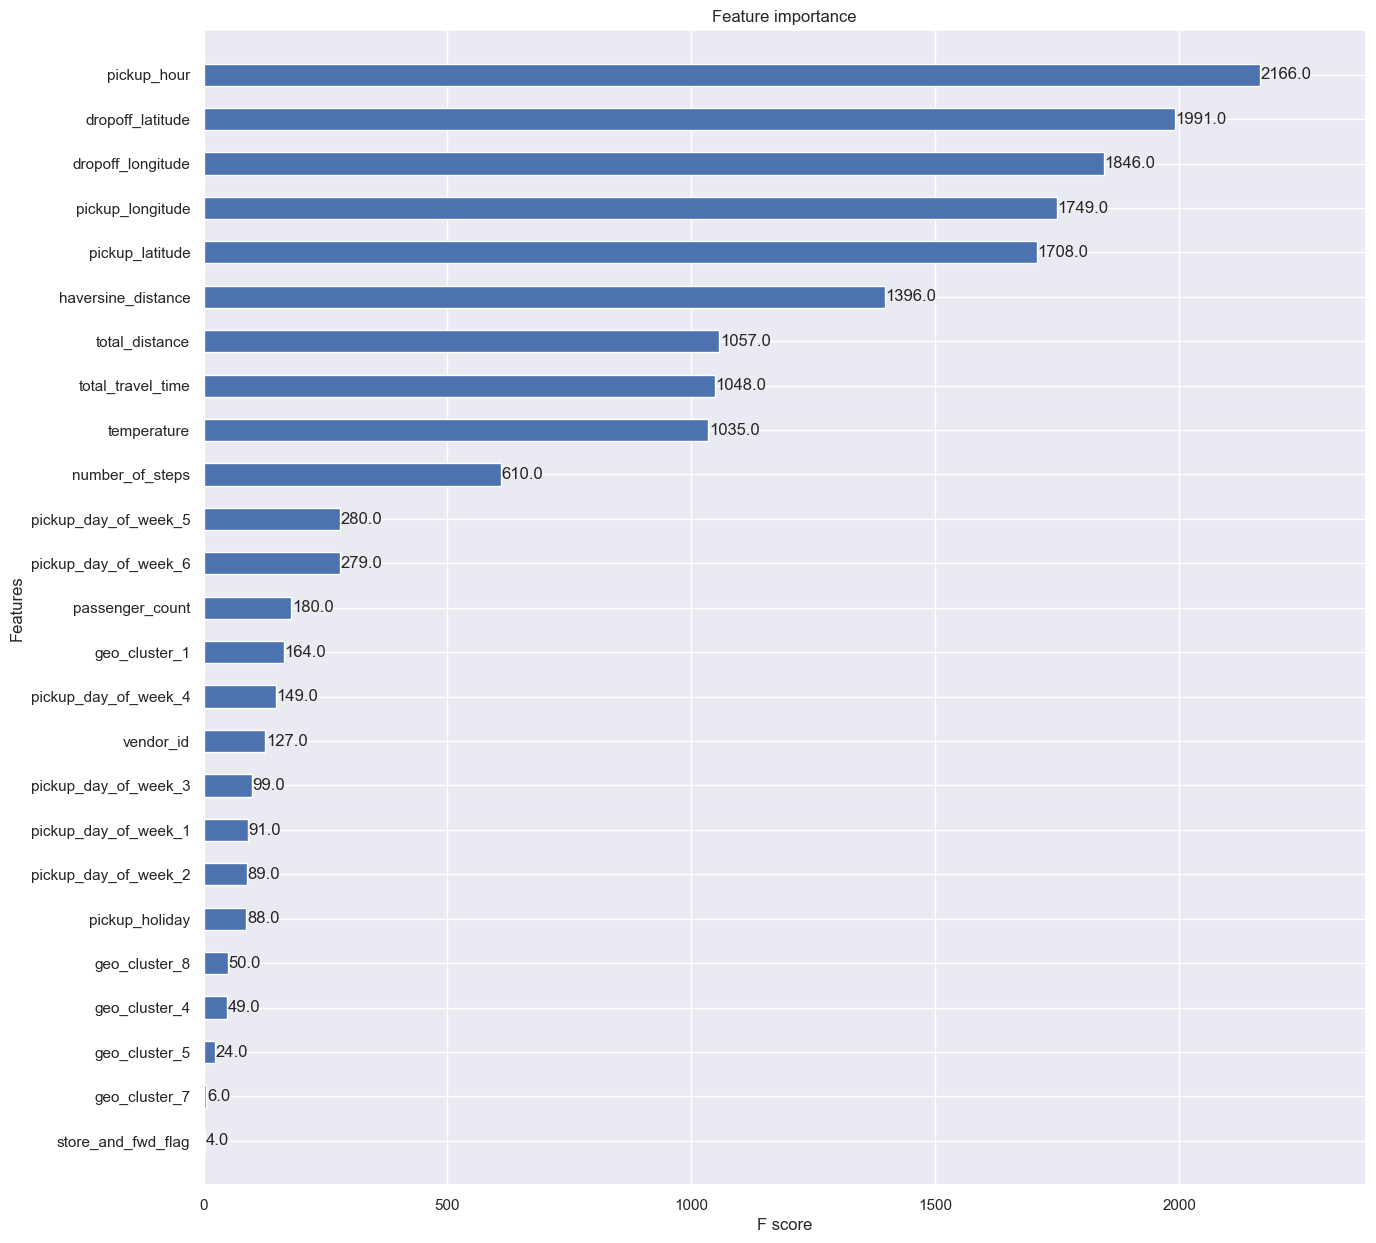

In [125]:
fig, ax = plt.subplots(figsize = (15,15))
xgb.plot_importance(model, ax = ax, height=0.5)

Для удовлетворения требованию гитхаба по лимиту датасетов:

find . -size +100M | cat >> .gitignore